# AlexNet Architecture

[Original Paper](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)


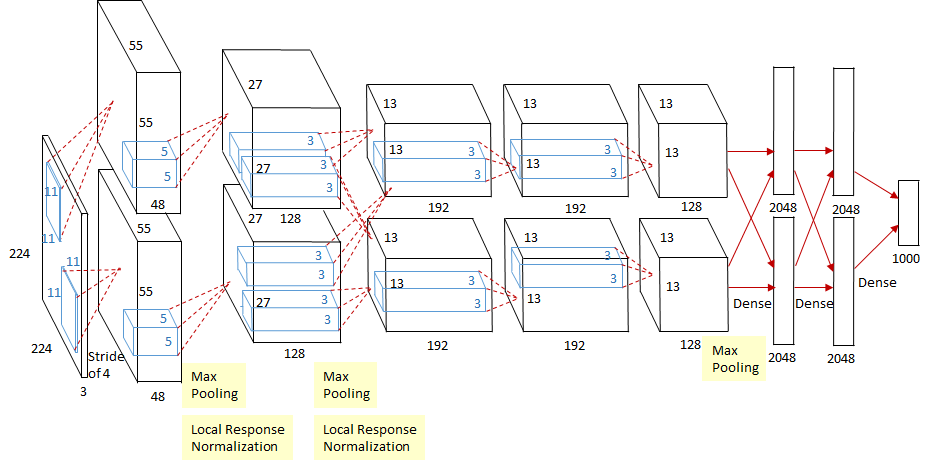




Here, you might be seeing two "paths" of processing through the network. This is due to the original AlexNet model being implemented on two GPUs in parallel. Almost all implementations of AlexNet are now on a single GPU and our implementation is too.


We will use the CIFAR 10 dataset, it consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. The classes are: 

`airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.`

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np
import time
import random
import copy

In [3]:
# RANDOM_SEED just to ensure the reproducibility of our experiments

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Data Pre-Processing

In [4]:
ROOT = '.data'

train_data = datasets.CIFAR10(root = ROOT,
                              train=True,
                              download=True)

means = train_data.data.mean(axis = (0,1,2)) / 255
stds = train_data.data.std(axis = (0,1,2)) / 255

print("Mean of the Data is: {}" .format(means))
print("STD of the Data is: {}" .format(stds))

Extracting .data/cifar-10-python.tar.gz to .data
Mean of the Data is: [0.49139968 0.48215841 0.44653091]
STD of the Data is: [0.24703223 0.24348513 0.26158784]


### Transforms for Data Augmentation

In [76]:
train_transforms = transforms.Compose([
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding = 2),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                    ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

Now we will load the dataset with our TRANSFORMATIONS

In [77]:
train_data = datasets.CIFAR10(ROOT,
                              train = True,
                              download = True,
                              transform = train_transforms)

test_data = datasets.CIFAR10(ROOT, 
                             train = False, 
                             download = True, 
                             transform = test_transforms)

train_data

Files already downloaded and verified
Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: .data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-5.0, 5.0], resample=False, expand=False)
               RandomHorizontalFlip(p=0.5)
               RandomCrop(size=(32, 32), padding=2)
               ToTensor()
               Normalize(mean=[0.49139968 0.48215841 0.44653091], std=[0.24703223 0.24348513 0.26158784])
           )

create a validation set from our training set....

In [78]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)

n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

len(train_data), len(valid_data)

(45000, 5000)

ensure our validation set uses the test transforms.

In [79]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transforms = test_transforms

In [80]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


## Helper Functions

Now, we'll create a function to plot some of the images in our dataset to see what they actually look like.
Note that by default PyTorch handles images that are arranged `[channel, height, width]`, but matplotlib expects images to be     
 `[height, width, channel],` hence we need to permute our images before plotting them.
Ignore the normalize argument for now, we'll explain it shortly.

In [81]:
def plot_images(images, labels, classes, normalize = False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

Then, we'll actually plot the images.
We get both the images and the labels from the training set and convert the labels, which are originally stored as integers, into their human readable class by using the data's classes dictionary.
When we plot them we see lots of warnings. This is because matplotlib is expecting the values of every pixel to be between  [0,1] , however our normalization will cause them to be outside this range. By default matplotlib will then clip these values into the  [0,1]  range. This clipping causes all of the images to look a bit weird - all of the colors are oversaturated.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

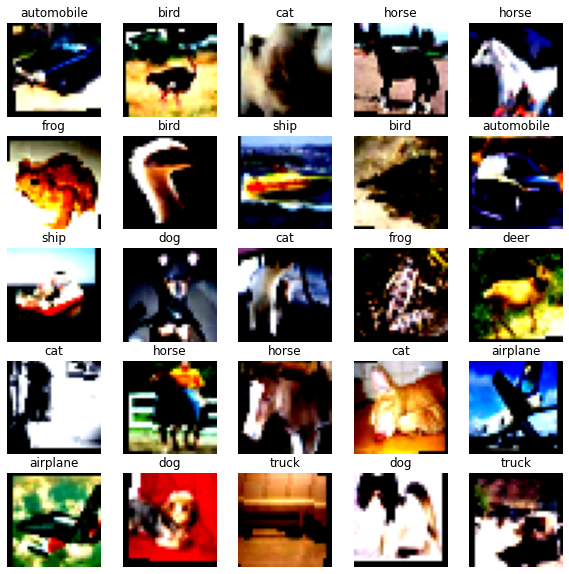

In [82]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes) 

A solution to this is to renormalize the images so each pixel is between  [0,1] . This is done by clipping the pixel values between the maximum and minimum within an image and then scaling each pixel between  [0,1]  using these maximum and minimums.
As we can see the images below look a lot more like we were expecting, along with the rotations and cropping.

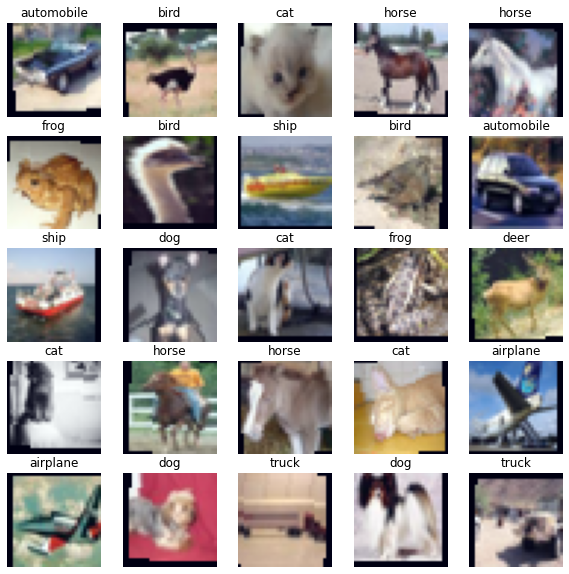

In [83]:
plot_images(images, labels, classes, normalize = True)

We'll be normalizing our images by default from now on, so we'll write a function that does it for us which we can use whenever we need to renormalize an image.

In [84]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

## Plotting FILTERED Images 
Can be used to output the ***`FEATURE MAP `*** of different Convolutional Layers

In [85]:
def plot_filter(images, filter, normalize = True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0).cpu()    # torch.Size([1, 1, 3, 3]) for the Horizontal filter in below cell

    print(filter.shape)
    filter = filter.repeat(3, 3, 1, 1)  # torch.Size([3 * N, 3 * C, 1 * H, 1 * W]) -- > Filter shape: torch.Size([3, 3, 3, 3])
    print(filter.shape)
    n_images = images.shape[0] # or n_images = N_IMAGES

    filtered_images = F.conv2d(images, filter)

    images = images.permute(0,2,3,1)
    filtered_images = filtered_images.permute(0,2,3,1)

    fig = plt.figure(figsize = (25,5))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)
            
        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(image)
        ax.set_title('Original')
        ax.axis('Off')

        if normalize:
            image = normalize_image(image)
            
        image = filtered_images[i]

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image)
        ax.set_title(f'Filtered')
        ax.axis('Off');



The filters are still 2-dimensional but they are expanded to a depth of three dimensions inside the plot_filter function.
Below is a filter which detects horizontal lines.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 3, 3])
torch.Size([3, 3, 3, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


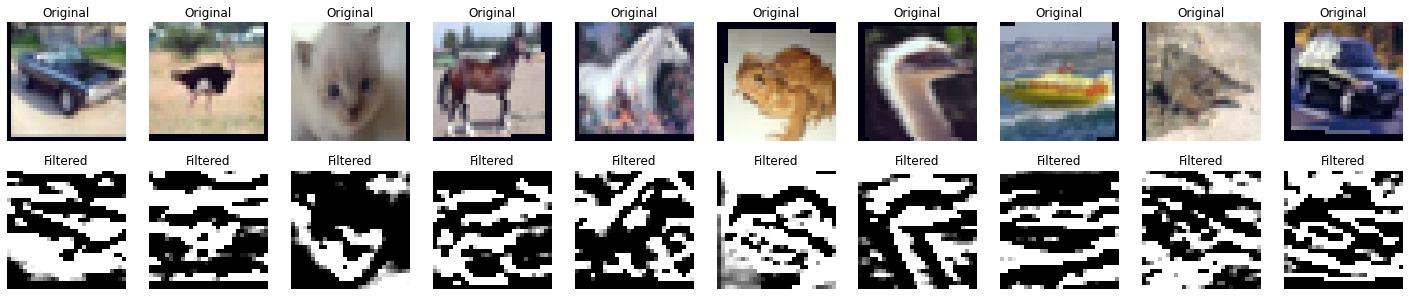

In [86]:
N_IMAGES = 10

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]

horizontal_filter = [[-1, -2, -1],
                     [ 0,  0,  0],
                     [ 1,  2,  1]]

plot_filter(images, horizontal_filter, normalize = True)

In [87]:
# CODE EXPLANATION for above cell

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]
print(images[1].shape)

print(images[1].unsqueeze(0).shape)

torch.Size([3, 32, 32])
torch.Size([1, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1, 3, 3])
torch.Size([3, 3, 3, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


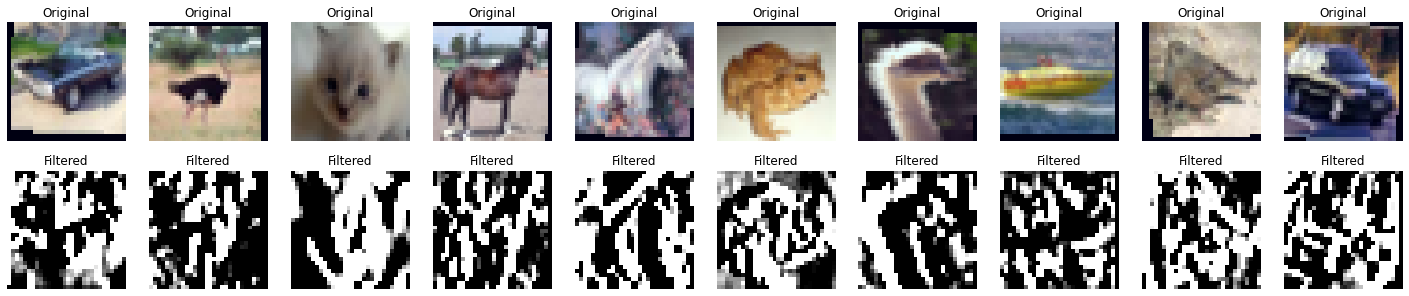

In [88]:
vertical_filter = [[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]]

plot_filter(images, vertical_filter)

For ***`SUBSAMPLING/POOLING`*** Layers

In [89]:
def plot_subsample(images, pool_type, pool_size, normalize = True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    
    if pool_type.lower() == 'max':
        pool = F.max_pool2d
    elif pool_type.lower() == 'mean' or 'avg':
        pool = F.avg_pool2d
    else:
        raise ValueError(f'pool_type must be either max or mean, got: {pool_type}')
    
    n_images = images.shape[0]
    
    pooled_images = pool(images, kernel_size = pool_size)

    images = images.permute(0, 2, 3, 1)
    pooled_images = pooled_images.permute(0, 2, 3, 1)

    fig = plt.figure(figsize = (25, 5))
    
    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(image)
        ax.set_title('Original')
        ax.axis('off')

        image = pooled_images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image)
        ax.set_title(f'Subsampled')
        ax.axis('off');

The higher filter sizes in the pooling layers means more information is lost, i.e. the image becomes lower resolution.

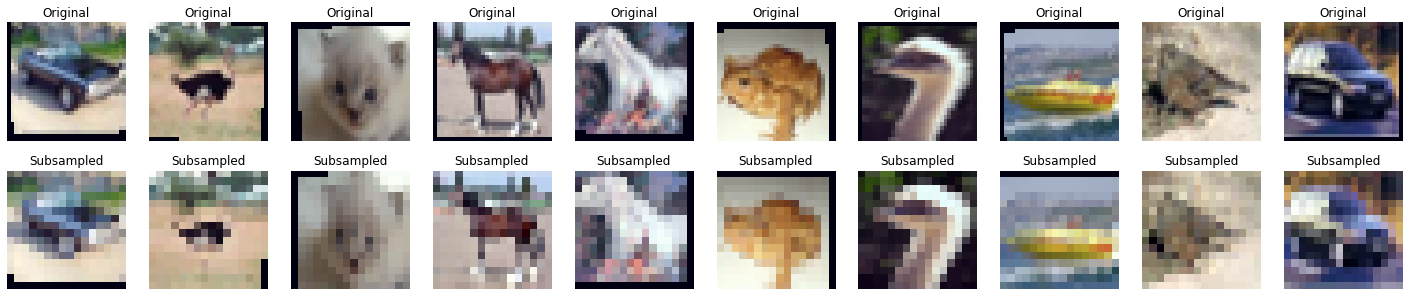

In [90]:
images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]

plot_subsample(images, 'max', 2)

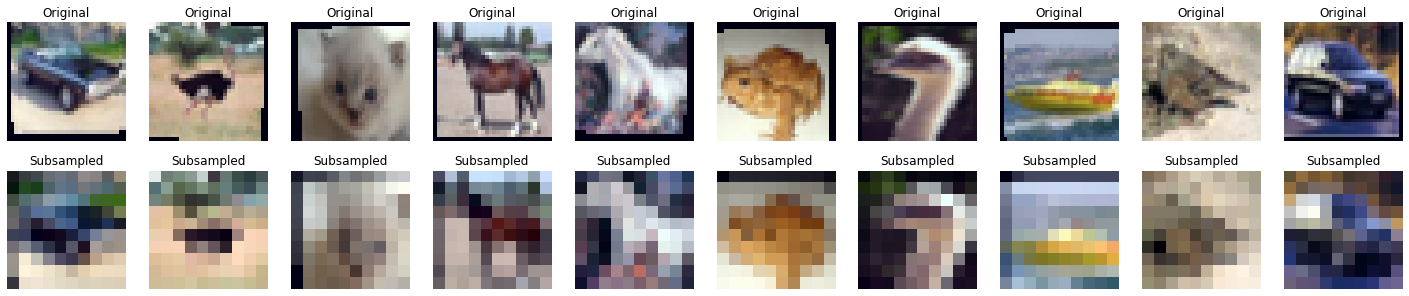

In [91]:
plot_subsample(images, 'avg', 3)

In [92]:
# Just FYI

images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu() # dim = 0 means "N" (First axis)
n_images = images.shape[0]
images.shape

torch.Size([10, 3, 32, 32])

Finally, last step is to create the Dataloader

In [93]:
BATCH_SIZE = 64

train_loader = data.DataLoader(train_data,
                               shuffle = True,
                               batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

test_loader = data.DataLoader(test_data,
                              shuffle = True,
                              batch_size = BATCH_SIZE)



# Model Architecture

### ***`Note:`*** We need to change the architecture in order to comply with our 32 X 32 size images, if we dont then the pooling layers will reduce our size to 0X0

Activation functions should be kept after the Convolutional and Pooling layers to reduce the computational cost

(As opposed to what we did in the previous Architecture Notebook)

In [97]:
# THIS is the OUTPUT of filters if we RESIZE Cifar10 dataset images to 227, 227

In [120]:
# IMP Point: In PyTorch, while using MaxPool2d, the DEFAULT value of stride is 
# equal to your kernel_size i.e (stride = kernel_size) by default

# Reference: https://discuss.pytorch.org/t/confusing-default-stride-in-pooling-layers/17024 


class Alexnet(nn.Module):
    def __init__(self, in_channels = 3, num_classes = 10):
        super(Alexnet, self).__init__()

        self.in_channels = in_channels
        
        # CONVOLUTIONAL Layers
        self.feature_extractor = nn.Sequential(
            
            # FIRST Conv Layer
            nn.Conv2d(in_channels, out_channels = 64, kernel_size = 3,
                      stride = 2, padding = 1), 
            nn.MaxPool2d(kernel_size = 2), 
            nn.ReLU(),
            nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75, k = 2),  # Section 3.3 of res paper
            
            # SECOND Conv Layer
            nn.Conv2d(64, 192, kernel_size = 3, padding = 1), 
            nn.MaxPool2d(kernel_size = 2), 
            nn.ReLU(), 
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),

            # THIRD Conv Layer
            nn.Conv2d(192, 384, kernel_size = 3, padding = 1), 
            nn.ReLU(),
            
            # FOURTH Conv Layer
            nn.Conv2d(384, 256, kernel_size=3, padding = 1), 
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, padding = 1), 
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2),  # (b x 256 x 2 x 2)
            nn.ReLU(),
        )

        # LINEAR Layers
        self.classifier = nn.Sequential(
            
            nn.Dropout(p=0.5, inplace = True),

            # FIRST Linear
            nn.Linear(in_features = (256 *2 *2), out_features = 4096),
            nn.ReLU(),

            nn.Dropout(p=0.5, inplace=True),

            # SECOND Linear
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),

            nn.Linear(in_features=4096, out_features=num_classes)
        )


    def forward(self, x):
      
        x = self.feature_extractor(x)
        x = x.view(-1, 256 * 2 * 2)
        return self.classifier(x)



# You can also write forward function as 

# x = self.feature_extractor(x)
# h = x.view(x.shape[0], -1)
# x = self.classifier(h)
# return x, h


# But just then remember to change the code below to
# y_pred, _ = model(x) because your model now return 2 values

In [121]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Alexnet(3, 10).to(device)
x = torch.randn(2, 3, 32, 32).to(device)

print(model(x).shape)


torch.Size([2, 10])


In [122]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,272,266 trainable parameters


### Weights Initialisation

In [123]:
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity = 'relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain = nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

In [124]:
model.apply(initialize_parameters)

Alexnet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (4): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
    (7): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): ReLU()
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=True)
    (1): Linear(in_features=102

In [125]:
from torchsummary import summary

summary(model, (3, 32, 32))  # Channels = 3

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           1,792
         MaxPool2d-2             [-1, 64, 8, 8]               0
              ReLU-3             [-1, 64, 8, 8]               0
 LocalResponseNorm-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 192, 8, 8]         110,784
         MaxPool2d-6            [-1, 192, 4, 4]               0
              ReLU-7            [-1, 192, 4, 4]               0
 LocalResponseNorm-8            [-1, 192, 4, 4]               0
            Conv2d-9            [-1, 384, 4, 4]         663,936
             ReLU-10            [-1, 384, 4, 4]               0
           Conv2d-11            [-1, 256, 4, 4]         884,992
             ReLU-12            [-1, 256, 4, 4]               0
           Conv2d-13            [-1, 256, 4, 4]         590,080
             ReLU-14            [-1, 25

## Learning Rate Finder

Reference:[PyTorch lr_finder()](https://github.com/davidtvs/pytorch-lr-finder)


The most commonly used optimizer used is Adam. Adam's default learning rate is usually a fine choice but, much like how we manually initialized our parameters to potentially get some performance improvement, we can try and calculate an optimal learning rate manually.

How does the learning rate finder work? We give the finder our model, optimizer and criterion we want to use. However we give it an optimizer with a much lower learning rate than we are expecting to use. We then train the model on the batches of data from the training set - calculating the loss and updating the parameters. After each batch we increase the learning rate exponentially from the initial, extremely low learning rate to a learning rate we know will be too high. This repeats until our loss diverges (over 5x the best loss achieved) or we reach our defined maximum learning rate. 

At each batch we are recording the learning rate and the loss achieved on that batch. By plotting them against each other we can find a suitable learning rate - but more on how to do that in a bit.

The losses calculated are usually quite noisy so we actually save the exponentially weighted average of the loss calculated. 

We also want to use our initialized parameters, not the ones obtained by upgrading the parameters when performing the learning rate finder. Hence we save the model parameters to disk when initializing the finder and then they are reset to our desired initialized ones just before the `range_test` function returns by loading the initial values from disk.

In [136]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')                        

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5): # Loss Divergence Threshold : keep 5x or 10x
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            lrs.append(lr_scheduler.get_last_lr()[0])

            #update lr
            lr_scheduler.step()
            
            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))

                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step() 
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

To prepare to use the range finder we define an initial, very low starting learning rate and then create an instance of the optimizer we want to use with that learning rate.
We then define the loss function we want to use, the device we'll use and place our model and criterion on to our device.

In [133]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr = START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

Next, we'll finally use the range finder.

We first create an instance of the finder class with the model, optimizer, loss function and device. Then we use `range_test` with the training iterator, the maximum learning rate and the number of iterations we want to use. 

In [137]:
%%time
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_loader, END_LR, NUM_ITER)

Stopping early, the loss has diverged
CPU times: user 54.7 s, sys: 4 s, total: 58.7 s
Wall time: 58.7 s


Next, we can plot the learning rate against the loss.
As our learning rate was scaled up exponentially we want to plot it on a logarithmic scale. We also do not want to plot the last few values as they are usually where the loss is very high and makes it difficult to examine the graph in detail. You can also skip the first few values as nothing interesting happens there.

In [130]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

Generally the loss begins flat (NOT here) and then begins to decrease rapidly before reaching a minimum and starting to increase. 

How can we read this plot and get the optimal learning rate? According to [this](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html) article, we should look for the loss begins to flatten, this is around $10^{-2}$ below, and then reduce that by a factor of 10, which gives us a found learning rate of $10^{-3}$ or $0.001$.

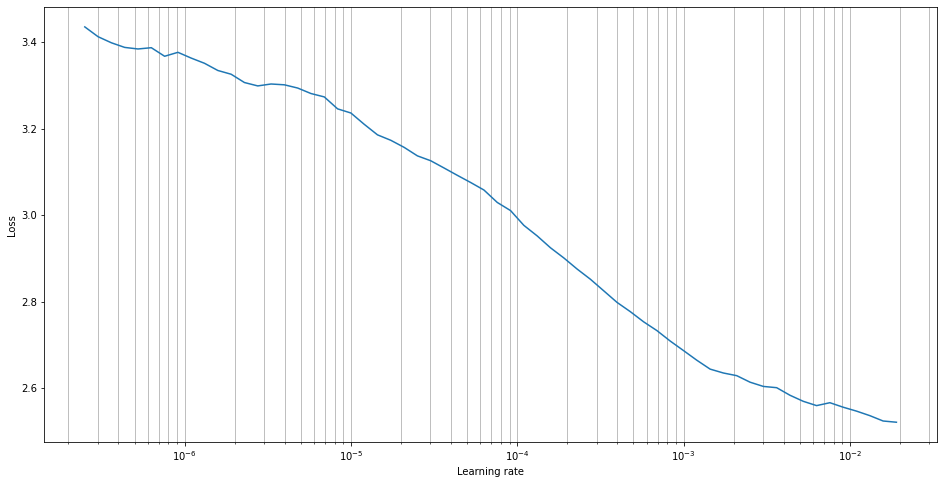

In [138]:
plot_lr_finder(lrs, losses) # For DIVERGENCE THRESHOLD = 5

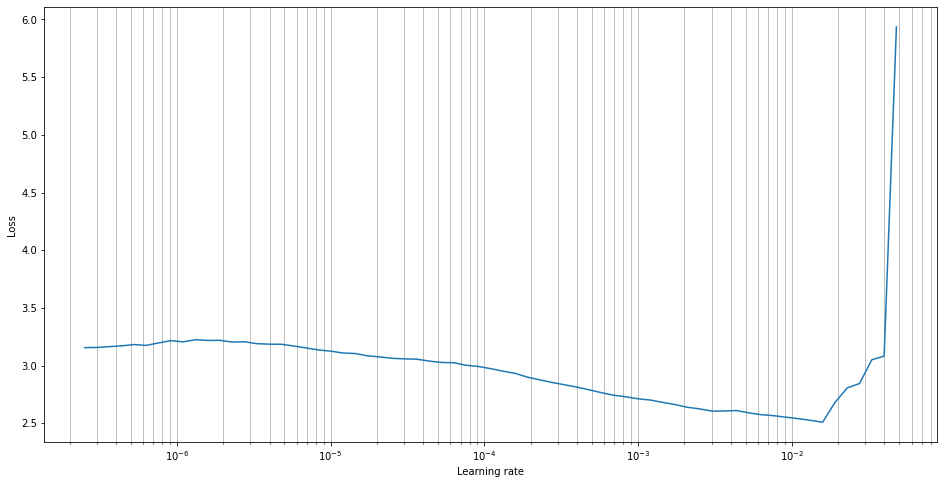

In [135]:
plot_lr_finder(lrs, losses) # For Divergence THRESHOLD = 10

# Essentially both are the SAME Graph only!

We can now create a new optimizer with our found learning rate.
Ironically, the learning rate value we found,  0.001  is actually Adam's default learning rate!

In [139]:
FOUND_LR = 1e-3

optimizer = optim.Adam(model.parameters(), lr = FOUND_LR)

### Function to Calculate Accuracy

In [140]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc


...and a function to implement our training loop.

As we are using dropout we need to make sure to "turn it on" when training by using `model.train()`.

In [146]:
def train(model, loader, optimizer, criterion, device ):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x,y) in loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss/len(loader), epoch_acc/len(loader)

In [148]:
def evaluate(model, loader, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    with torch.no_grad():

      for (x,y) in loader:
          x = x.to(device)
          y = y.to(device)

          y_pred = model(x)
          loss - criterion(y_pred, y)
          acc = calculate_accuracy(y_pred, y)

          epoch_loss += loss.item()
          epoch_acc += acc.item()

    return epoch_loss/len(loader), epoch_acc/len(loader)

For measuring epoch time

In [143]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [149]:
EPOCHS = 25

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pth')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

KeyboardInterrupt: ignored